## Time-Series Analysis (10 Minute Sliding Window)

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Capstone/labeled_patient_eda_hrv_features_60s.csv")
df.drop(columns=['HRV_SDANN'], inplace=True)

# Define constants
window_size = 10
feature_cols = [
    'SCL_Mean', 'SCL_STD', 'SCR_Peaks_Count', 'HRV_RMSSD', 'HRV_SDNN', 'HRV_pNN50',
    'HRV_MeanRR', 'HRV_MedianRR', 'HRV_HF', 'HRV_LF', 'HRV_LF_HF_Ratio',
    'HRV_SampEN'
]

# Build dataset
X_all, y_all, group_ids = [], [], []

for patient_id, group in df.groupby('Patient_ID'):
    group = group.dropna(subset=['PANAS_NA']).reset_index(drop=True)
    group = group.replace([np.inf, -np.inf], np.nan).dropna(subset=feature_cols)
    if len(group) <= window_size:
        continue

    scaler = MinMaxScaler()
    try:
        group[feature_cols] = scaler.fit_transform(group[feature_cols])
    except ValueError:
        continue

    for i in range(window_size, len(group)):
        window_feat = group.iloc[i - window_size:i][feature_cols].values[:-1].flatten()
        past_labels = group.iloc[i - window_size:i]['PANAS_NA'].values[:-1]
        full_features = np.concatenate([window_feat, past_labels])
        target = group.iloc[i]['PANAS_NA']

        X_all.append(full_features)
        y_all.append(target)
        group_ids.append(patient_id)

X_all = np.array(X_all)
y_all = np.array(y_all)
group_ids = np.array(group_ids)

# Define models and hyperparameter grids
models = {
     "LinearRegression": (LinearRegression(), {}),
    "RandomForest": (RandomForestRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 3]
    }),
    "DecisionTree": (DecisionTreeRegressor(), {
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 3]
    }),
    "XGBoost": (XGBRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1],
        "reg_lambda": [1, 5],
        "subsample": [0.7, 1.0]
    }),
    "LightGBM": (LGBMRegressor(), {
        "n_estimators": [50, 100],
        "max_depth": [3, 5, 10],
        "learning_rate": [0.01, 0.1],
        "reg_lambda": [0.0, 1.0]
    }),
    "AdaBoost": (AdaBoostRegressor(), {
        "n_estimators": [50, 100],
        "learning_rate": [0.1, 0.5, 1.0]
    }),
    "SVM": (SVR(), {
        "kernel": ["linear", "rbf"],
        "C": [0.1, 1.0, 10.0],
        "epsilon": [0.1, 0.5, 1.0]
    }),
}

# List of models that require feature scaling
scale_sensitive_models = ["SVM", "LinearRegression"]

# Prepare GroupKFold
gkf = GroupKFold(n_splits=5)

# Store best models and evaluation metrics
evaluation_results = []

# Perform hyperparameter tuning and evaluation
for model_name, (model, param_grid) in models.items():
    best_model = None
    best_score = 0
    all_preds = []
    all_true = []

    for train_idx, test_idx in gkf.split(X_all, y_all, groups=group_ids):
        X_train, X_test = X_all[train_idx], X_all[test_idx]
        y_train, y_test = y_all[train_idx], y_all[test_idx]

        # Apply MinMaxScaler only if model is scale-sensitive
        if model_name in scale_sensitive_models:
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    # Final evaluation
    mse = mean_squared_error(all_true, all_preds)
    mae = mean_absolute_error(all_true, all_preds)
    r2 = r2_score(all_true, all_preds)

    evaluation_results.append({
        'Model': model_name,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Best Params': grid.best_params_,
    })

# Display results in a DataFrame (excluding confusion matrix)
results_df = pd.DataFrame([{k: v for k, v in r.items()} for r in evaluation_results])

results_df


Output hidden; open in https://colab.research.google.com to view.

In [3]:
pd.set_option('display.max_colwidth', None)

results_df

,Model,MSE,MAE,R2,Best Params
0,LinearRegression,14.282021,2.465288,0.542154,{}
1,RandomForest,14.979747,2.054246,0.519786,"{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}"
2,DecisionTree,21.492265,2.415744,0.311011,"{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}"
3,XGBoost,15.178603,2.222264,0.513412,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_lambda': 5, 'subsample': 1.0}"
4,LightGBM,14.810258,2.148771,0.525220,"{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'reg_lambda': 0.0}"
5,AdaBoost,16.315223,2.516459,0.476974,"{'learning_rate': 0.1, 'n_estimators': 50}"
6,SVM,13.478229,1.539946,0.567921,"{'C': 10.0, 'epsilon': 1.0, 'kernel': 'linear'}"


In [4]:
results_df.to_csv("/content/drive/MyDrive/Capstone/results/time-series_NA_best_models.csv")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18058
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 108
[LightGBM] [Info] Start training from score 15.581227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

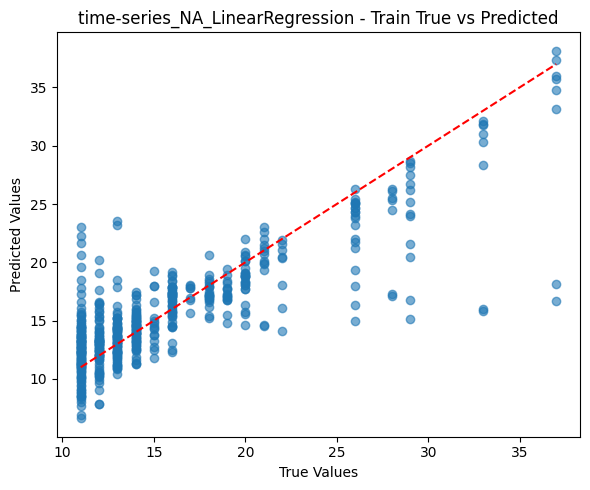

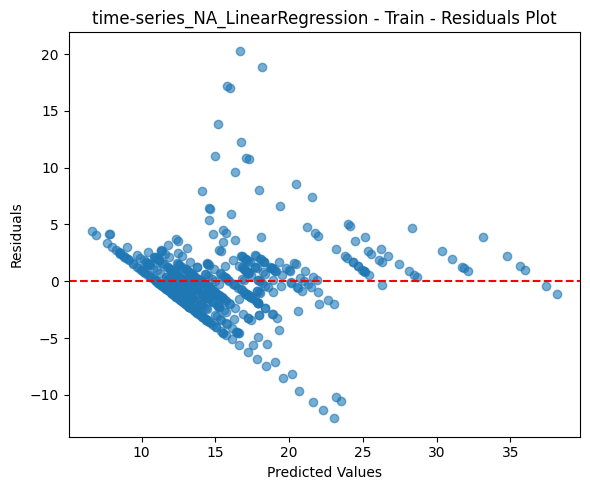

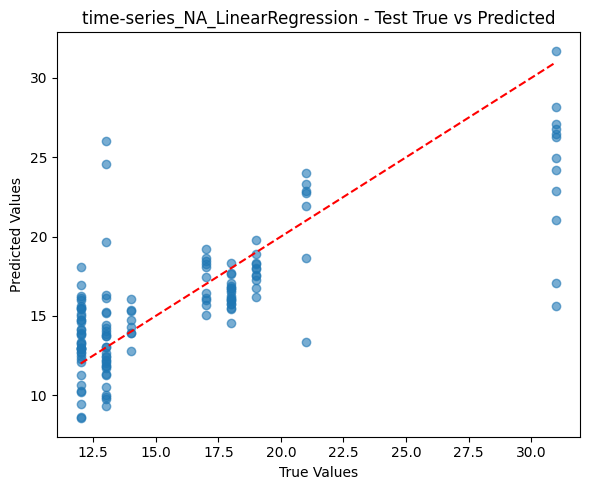

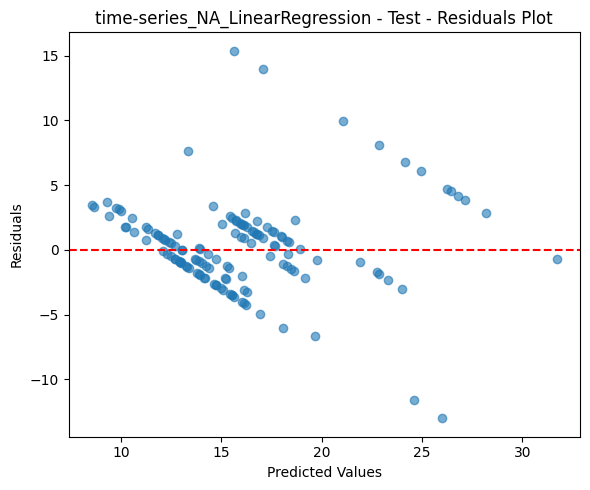

Evaluating RandomForest...


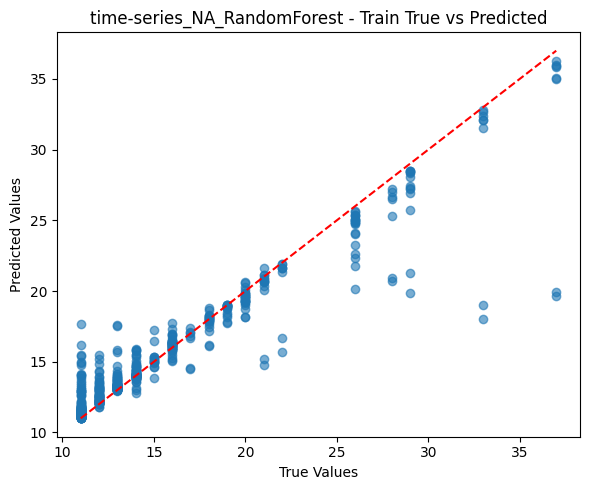

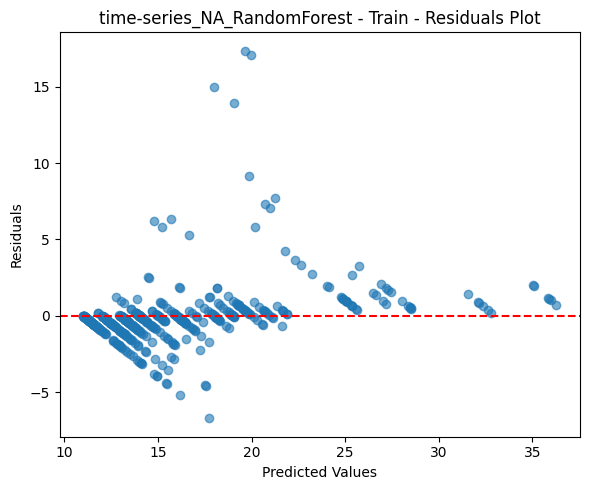

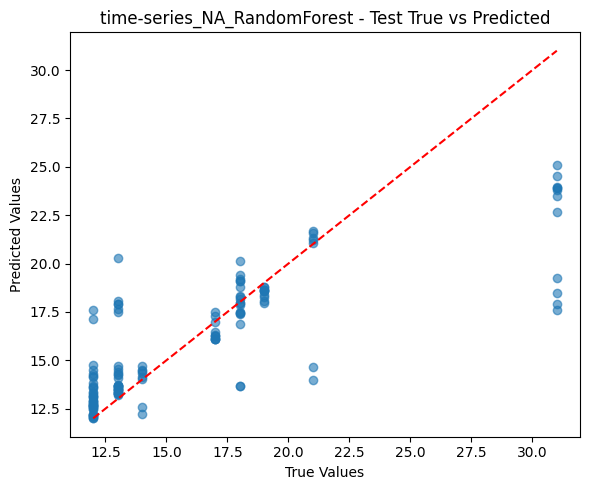

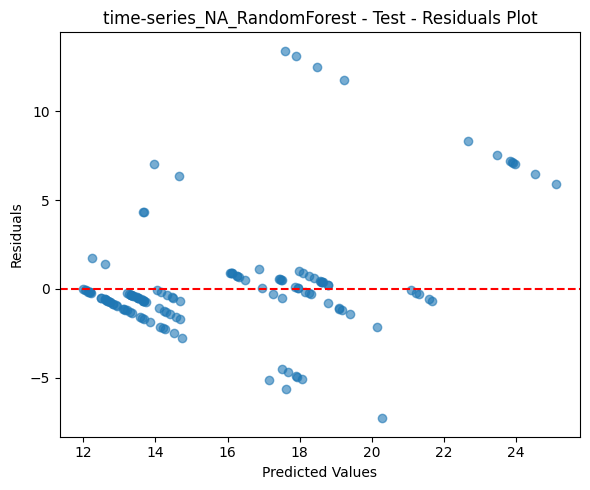

Evaluating DecisionTree...


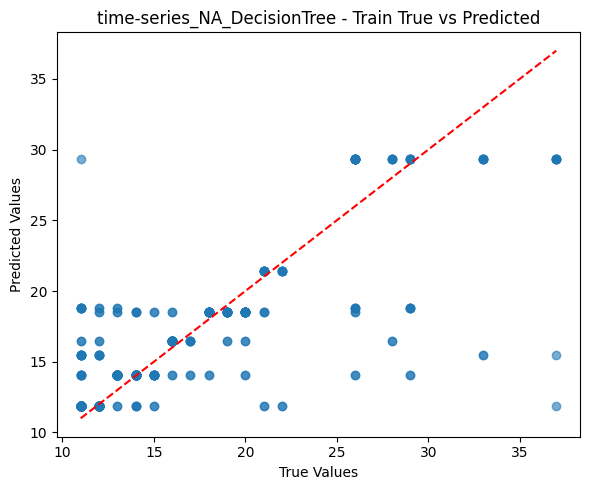

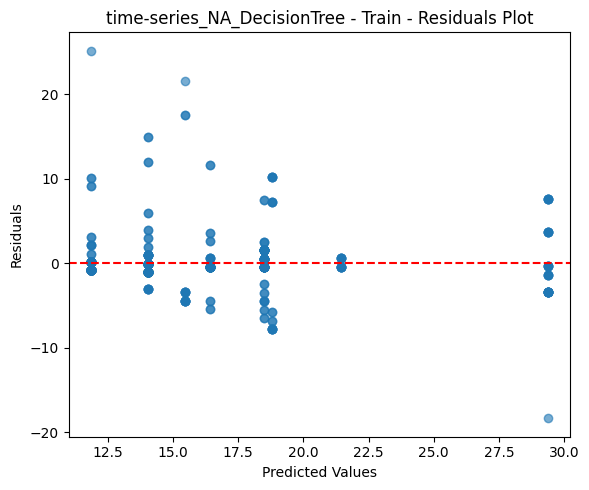

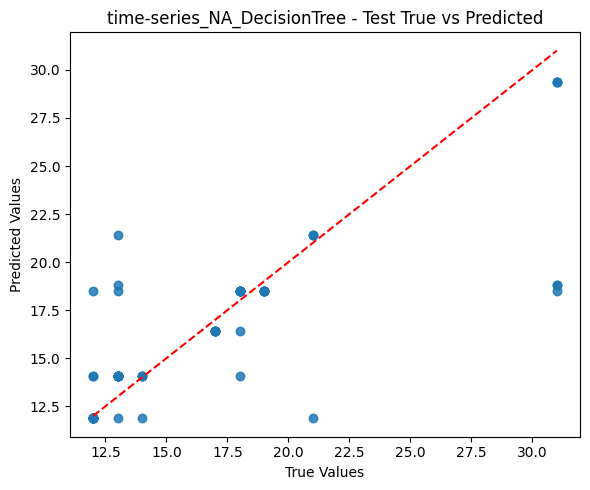

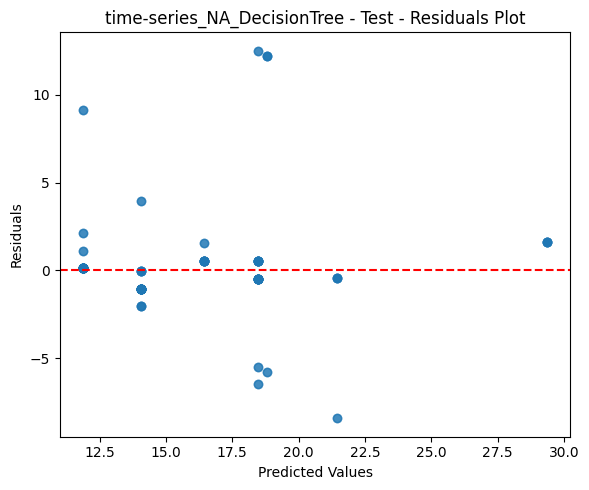

Evaluating XGBoost...


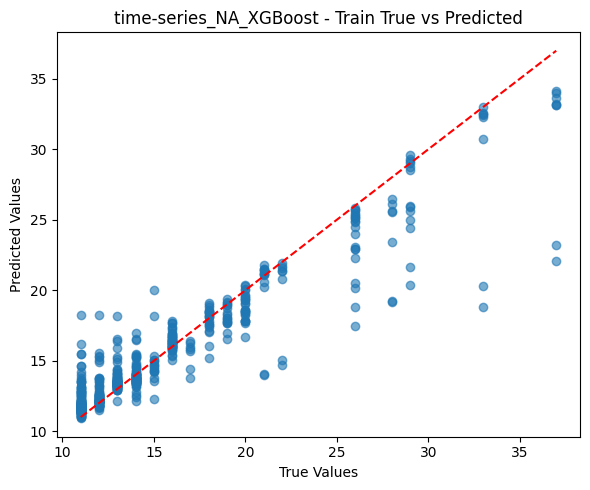

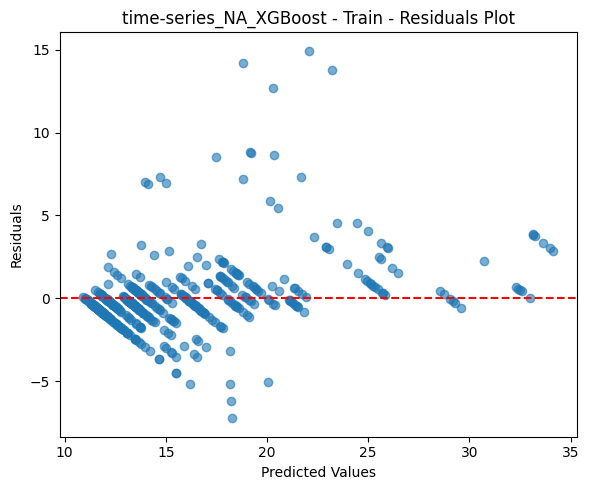

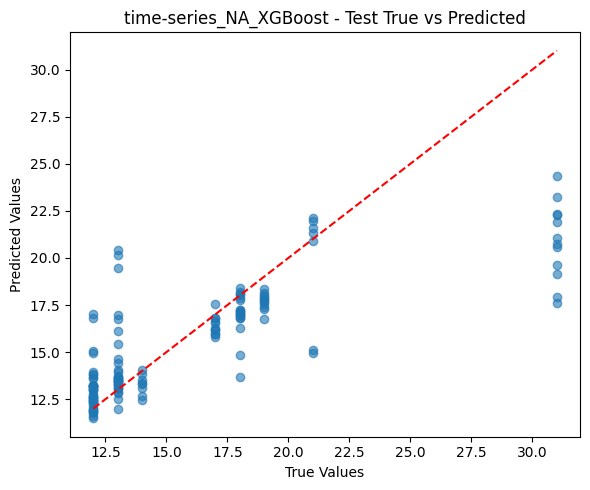

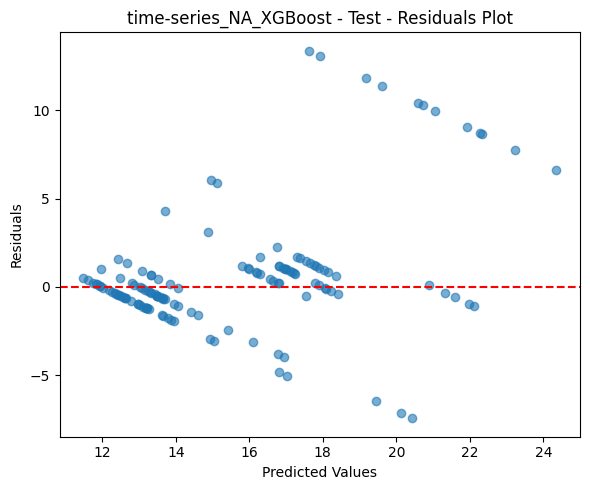

Evaluating LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


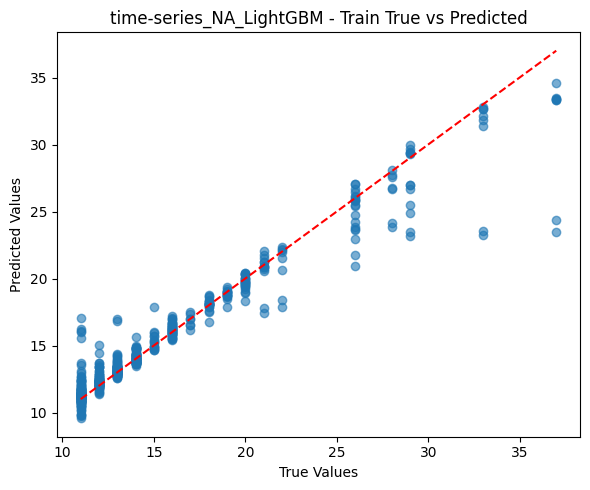

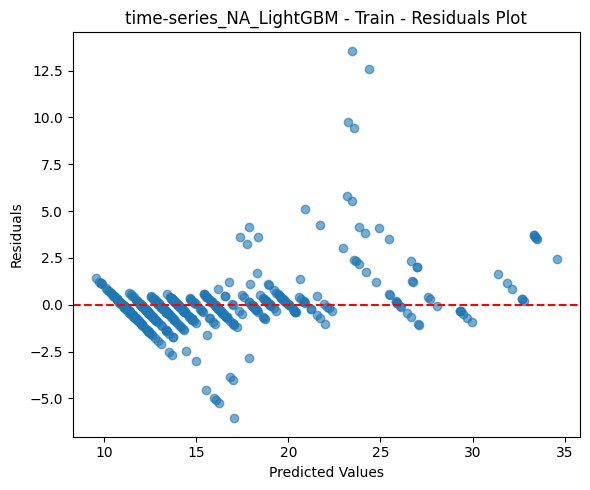

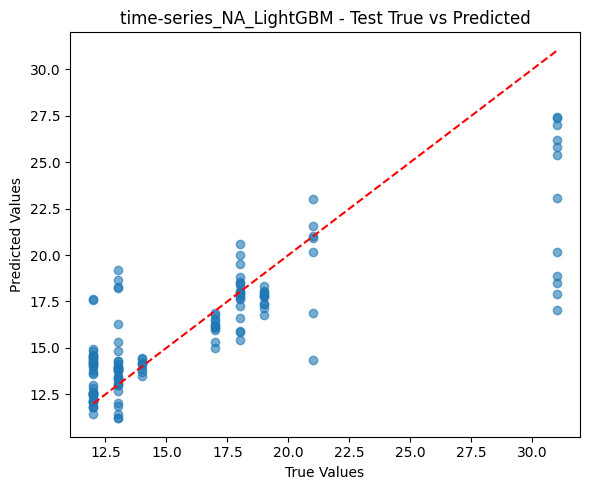

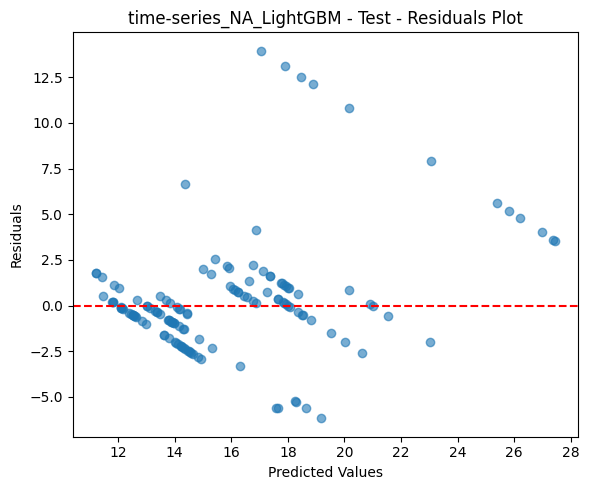

Evaluating AdaBoost...


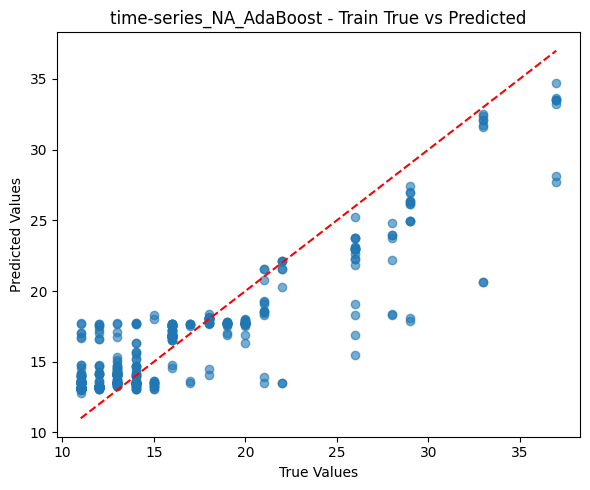

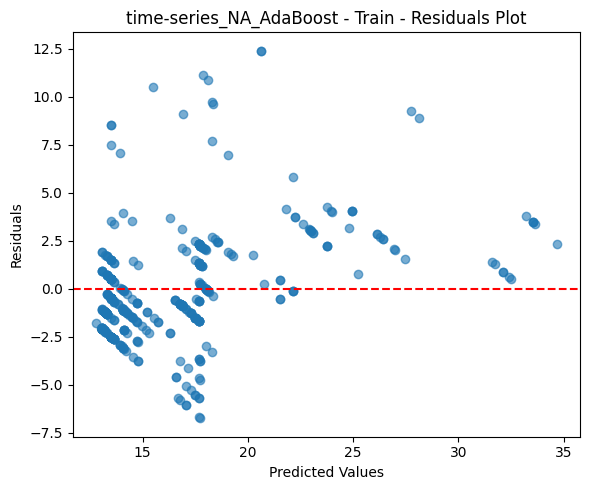

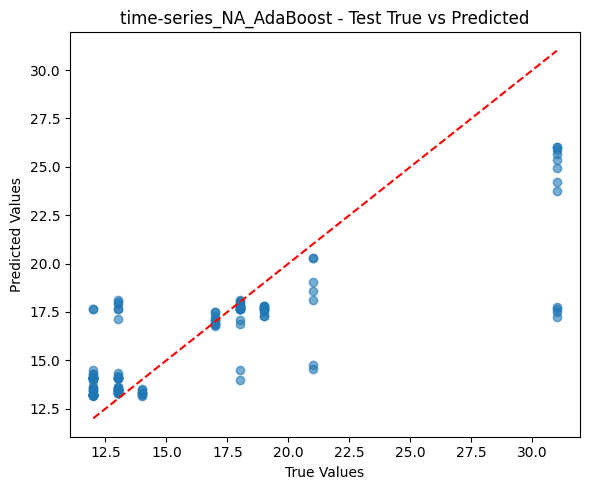

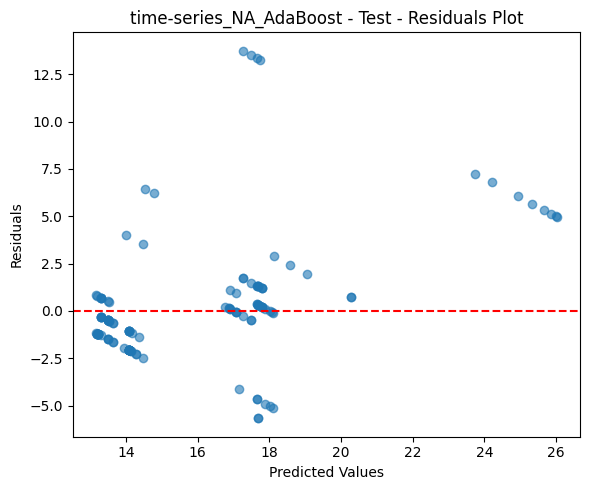

Evaluating SVM...


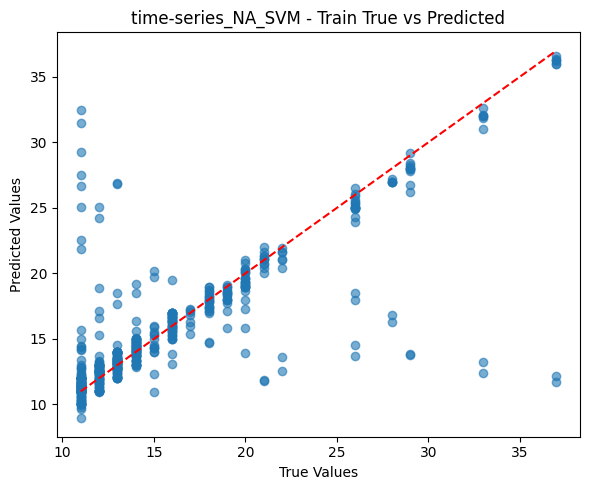

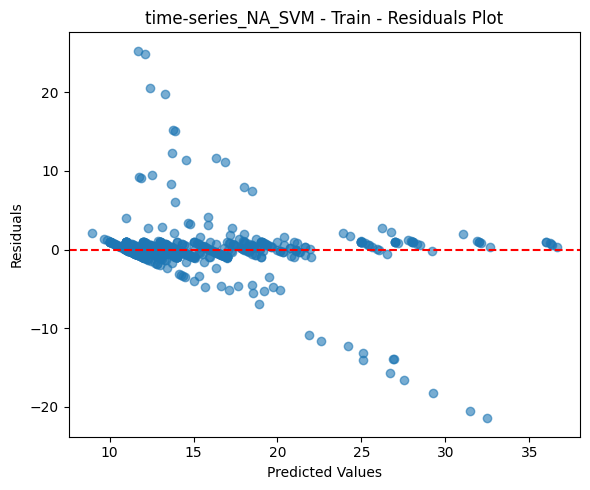

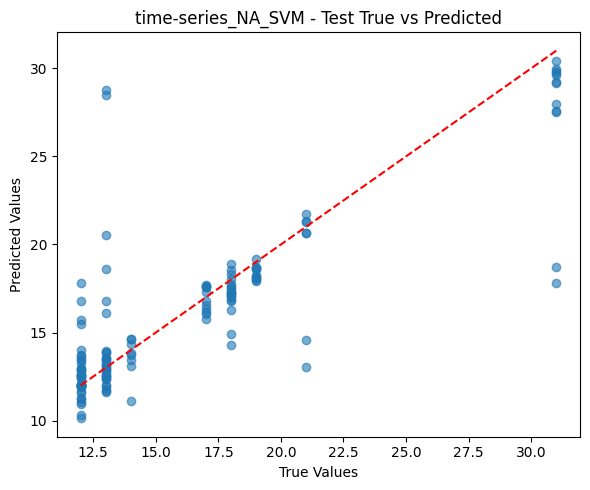

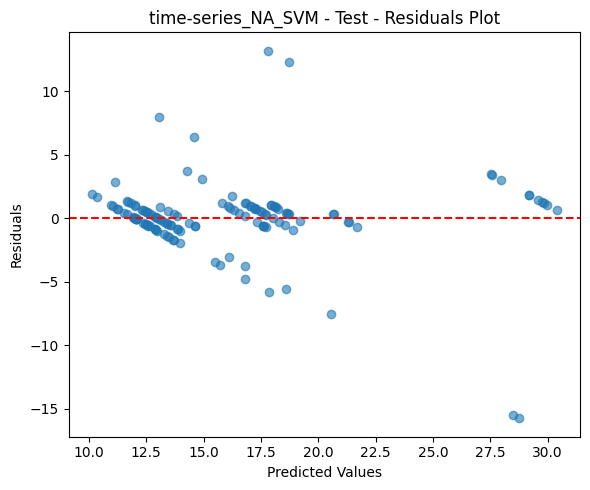

              Model  Train MSE   Test MSE  Train MAE  Test MAE  Train R2  \
0  LinearRegression  10.128379  12.212716   2.036351  2.385826  0.680293   
1      RandomForest   3.808820  10.930218   0.913824  1.866897  0.879773   
2      DecisionTree  11.789401  11.205245   1.779413  1.666966  0.627862   
3           XGBoost   4.457706  12.477309   1.164945  1.993188  0.859291   
4          LightGBM   2.232277  10.424957   0.721726  1.930220  0.929537   
5          AdaBoost   6.776324  10.730588   1.928807  2.003146  0.786102   
6               SVM  12.995474   9.119323   1.510077  1.518091  0.589792   

    Test R2  
0  0.577455  
1  0.621828  
2  0.612312  
3  0.568300  
4  0.639309  
5  0.628735  
6  0.684483  


In [5]:
from evaluation import full_regression_evaluation

# Define your best models
best_models = {
    "LinearRegression": LinearRegression().fit(X_train, y_train),
    "RandomForest": RandomForestRegressor(max_depth=None, min_samples_leaf=3, min_samples_split=5, n_estimators=100).fit(X_train, y_train),
    "DecisionTree": DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=5).fit(X_train, y_train),
    "XGBoost": XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=50, reg_lambda=5, subsample=1.0).fit(X_train, y_train),
    "LightGBM": LGBMRegressor(learning_rate=0.1, max_depth=10, n_estimators=50, reg_lambda=0.0).fit(X_train, y_train),
    "AdaBoost": AdaBoostRegressor(learning_rate=0.1, n_estimators=50).fit(X_train, y_train),
    "SVM": SVR(C=10.0, epsilon=1.0, kernel='linear').fit(X_train, y_train)
    }

# Store evaluation results
evaluation_summaries = []

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    results = full_regression_evaluation(model, X_train, y_train, X_test, y_test, model_name, data_type="time-series_NA")

    evaluation_summaries.append({
        'Model': model_name,
        'Train MSE': results['Train']['MSE'],
        'Test MSE': results['Test']['MSE'],
        'Train MAE': results['Train']['MAE'],
        'Test MAE': results['Test']['MAE'],
        'Train R2': results['Train']['R2'],
        'Test R2': results['Test']['R2']
    })

# Convert to DataFrame for comparison
eval_df = pd.DataFrame(evaluation_summaries)
print(eval_df)


In [6]:
eval_df.to_csv("/content/drive/MyDrive/Capstone/results/time-series_NA_best_models_eval.csv")

In [7]:
# Generate time-aware feature names
time_steps = 10
label_feature_names = [f'past_NA_t-{i}' for i in reversed(range(1, time_steps + 1))]

# Create time-aware feature names
time_series_features = []
for i in reversed(range(1, time_steps + 1)):
    time_series_features.extend([f'{f}_t-{i}' for f in feature_cols])

# Final feature name list
full_feature_names = time_series_features + label_feature_names


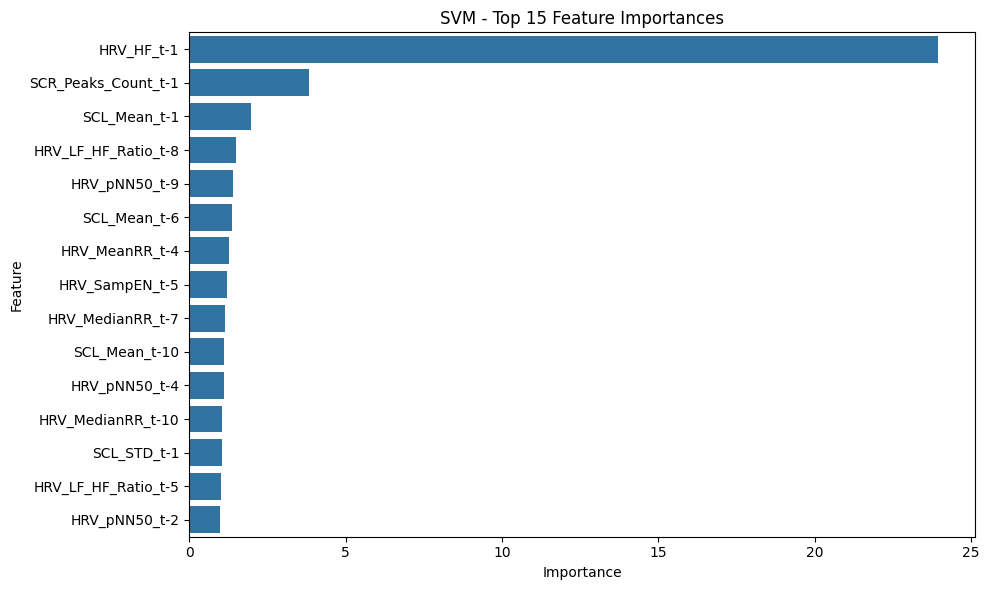

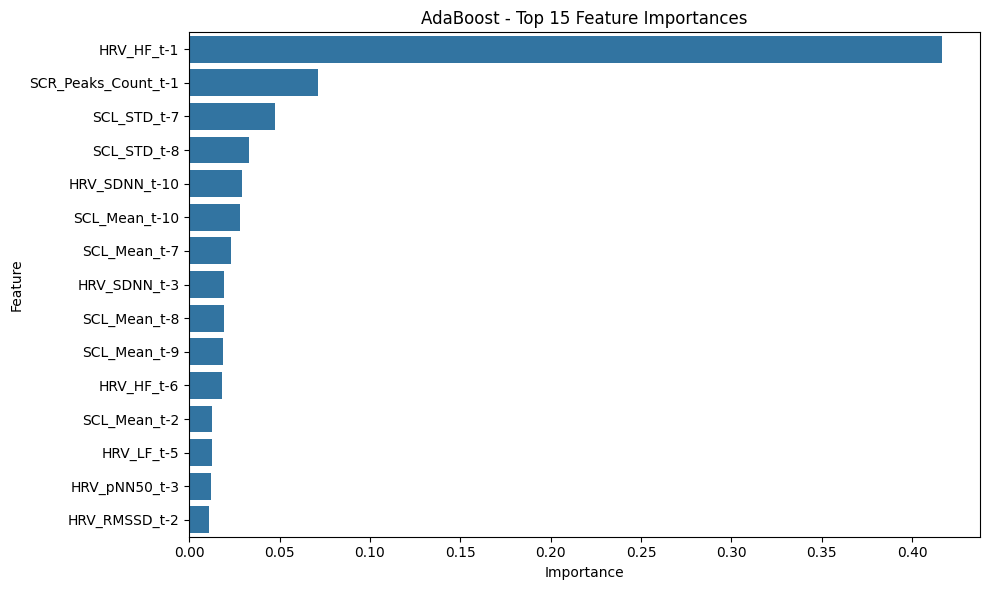

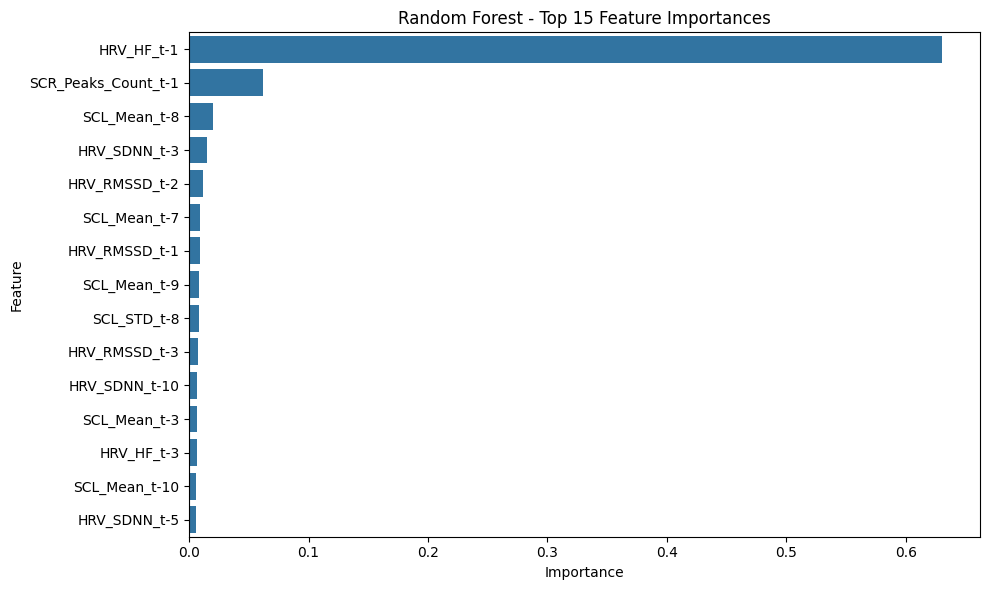

In [8]:
from feature_importance import plot_feature_importance

# Define your best models
best_svm_model = best_models['SVM']
best_ada_model = best_models['AdaBoost']
best_rf_model = best_models['RandomForest']
# Example usage with your trained models
plot_feature_importance(best_svm_model, full_feature_names, model_name="SVM", coef_type = "coef", save_path="/content/drive/MyDrive/Capstone/figures/time-series_svm_NA_importances.png")
plot_feature_importance(best_ada_model, full_feature_names, model_name="AdaBoost", save_path="/content/drive/MyDrive/Capstone/figures/time-series_ada_NA_importances.png")
plot_feature_importance(best_rf_model, full_feature_names, model_name="Random Forest", save_path = "/content/drive/MyDrive/Capstone/figures/time-series_rf_NA_importances.png")